In [1]:
from ib_insync import *
import src.floor_ceiling_regime as fcr
import scripts.trend_viewer
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7496, clientId=0)

<IB connected to 127.0.0.1:7496 clientId=0>

In [2]:
%matplotlib inline

In [3]:
c = ib.reqContractDetails(Contract(symbol='MES', secType='FUT', includeExpired=False))
c_df = util.df(c)
c_df

,contract,marketName,minTick,orderTypes,validExchanges,priceMagnifier,underConId,longName,contractMonth,industry,...,callable,putable,coupon,convertible,maturity,issueDate,nextOptionDate,nextOptionType,nextOptionPartial,notes
0,"Contract(secType='FUT', conId=586139726, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202312,,...,False,False,0,False,,,,,False,
1,"Contract(secType='FUT', conId=603558929, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202403,,...,False,False,0,False,,,,,False,
2,"Contract(secType='FUT', conId=620731036, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202406,,...,False,False,0,False,,,,,False,
3,"Contract(secType='FUT', conId=637533398, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202409,,...,False,False,0,False,,,,,False,
4,"Contract(secType='FUT', conId=654503314, symbo...",MES,0.25,"ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALLOC,AVGCOST,B...",CME,1,362673777,Micro E-Mini S&P 500 Stock Price Index,202412,,...,False,False,0,False,,,,,False,


In [11]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


def run(symbol, sec_type, interval='1 min', duration='1 D', use_rth=True):
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[1]
    contract = contracts.contract
    _bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=True
    )
    def fc_data_from_bars(bars):
        prices = util.df(bars).reset_index().rename(columns={'index': 'bar_number'})
        tables = fcr.fc_scale_strategy_live(prices, find_retest_swing=True)
        tables.enhanced_price_data = tables.enhanced_price_data[['close']].reset_index().rename(columns={'index': 'bar_number'})
        return tables
    
    def plot_fc_tables(tables, title):
        plot_prices = tables.enhanced_price_data.copy()
        plot_prices = scripts.trend_viewer.setup_trend_view_graph_simple(
            plot_prices, 
            tables.regime_table, 
            tables.peak_table, 
            tables.floor_ceiling_table
        )
        scripts.trend_viewer.plot(plot_prices[-300:], title)
        plt.show()
        clear_output(wait=True)
    
    def onBarUpdate(bars, hasNewBar):
        title = f'{bars.contract.symbol} {bars[-2].date}'
        if hasNewBar:
            tables = fc_data_from_bars(bars[:-1])
            plot_fc_tables(tables, title)
        
    _bars.updateEvent += onBarUpdate

    ib.sleep(100000)
    ib.cancelHistoricalData(_bars)

In [ ]:
run(
    symbol='MES', 
    sec_type='FUT',
    interval='1 min',
    duration='1 D',
    use_rth=False,
)

KeyboardInterrupt: 

In [14]:

def run_static(symbol, sec_type, interval='1 min', duration='1 D', use_rth=True, find_retest_swing=True):
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[1]
    contract = contracts.contract
    bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=False
    )
    prices = util.df(bars).reset_index().rename(columns={'index': 'bar_number'})
    tables = fcr.fc_scale_strategy_live(prices, find_retest_swing=find_retest_swing)
    tables.enhanced_price_data = tables.enhanced_price_data[['close']].reset_index().rename(columns={'index': 'bar_number'})
    tables.enhanced_price_data = scripts.trend_viewer.setup_trend_view_graph_simple(
        tables.enhanced_price_data, 
        tables.regime_table, 
        tables.peak_table, 
        tables.floor_ceiling_table
    )
    return tables

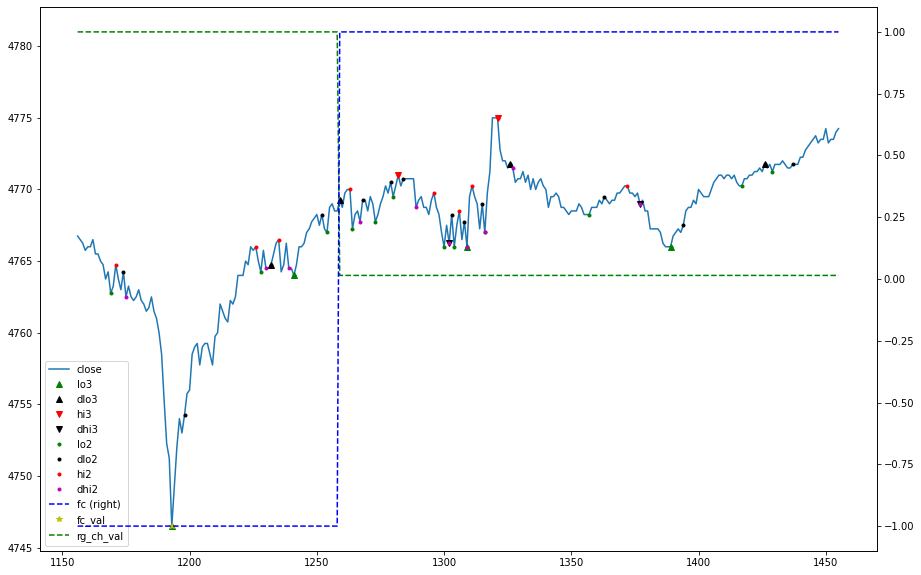

In [28]:
_tables = run_static(
    symbol='MES', 
    sec_type='FUT',
    interval='1 min',
    duration='2 D',
    use_rth=False,
    find_retest_swing=True
)

scripts.trend_viewer.plot(_tables.enhanced_price_data[-300:], '')